## Построение скелета и выпуклой оболочки бинарного изображения

In [1]:
from scipy.ndimage import morphology
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Введем операцию $\bigotimes$ из теории.

In [2]:
def unnamed_operation(x, a, b):
    lm = morphology.binary_erosion(x, a)
    rm = morphology.binary_erosion(np.logical_not(x), b)
    return np.logical_and(lm, rm)

И через нее операции утолщения и утоньшения.

In [3]:
def thickening(x, a, b):
    return np.logical_or(x, unnamed_operation(x, a, b))

def thinning(x, a, b):
    return np.logical_and(x, np.logical_not(unnamed_operation(x, a, b)))

Возьмем полюбившуюся лошадку.

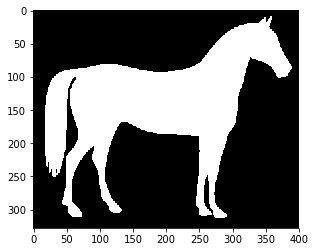

In [4]:
from skimage import data

horse = np.logical_not(data.horse())
plt.imshow(horse, cmap='gray')

Сгенерируем блоки для построения скелета.

In [5]:
def generate_t_structures():
    t = [None] * 8
    t[0] = np.array([
        [1,1,1],
        [0,1,0],
        [0,0,0]
    ], dtype=bool), np.array([
        [0,0,0],
        [0,0,0],
        [1,1,1]
    ], dtype=bool)
    for i in range(3):
        t[i+1] = np.rot90(t[i][0]), np.rot90(t[i][1])
    t[4] = np.array([
        [0,1,0],
        [0,1,1],
        [0,0,0]
    ], dtype=bool), np.array([
        [0,0,0],
        [1,0,0],
        [1,1,0]
    ], dtype=bool)
    for i in range(4, 7):
         t[i+1] = np.rot90(t[i][0]), np.rot90(t[i][1])
    return t

И реализуем итерационный алгоритм его построения.

In [6]:
def thinning_skeletonize(image):
    t = generate_t_structures()
    previous_skeleton = np.zeros(image.shape)
    skeleton = image.copy()
    while np.logical_xor(previous_skeleton, skeleton).any():
        previous_skeleton = skeleton.copy()
        for i in range(8):
            skeleton = thinning(skeleton, *t[i])
    return skeleton

Результат:

CPU times: user 2.02 s, sys: 22.1 ms, total: 2.05 s
Wall time: 2.08 s


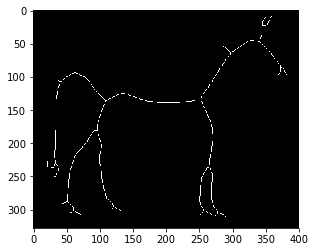

In [7]:
%%time
skeleton = thinning_skeletonize(horse)
plt.imshow(skeleton, cmap='gray')

Генерируем блоки для построения 45-выпуклой оболочки

In [8]:
def generate_another_t_structures():
    t = [None] * 8
    point =  np.array([
        [0,0,0],
        [0,1,0],
        [0,0,0]
    ], dtype=bool)
    t[0] = np.array([
        [1,1,1],
        [0,0,1],
        [0,0,0]
    ], dtype=bool), point.copy()
    for i in range(3):
        t[i+1] = np.rot90(t[i][0]), point.copy()
    t[4] = np.array([
        [1,1,1],
        [1,0,0],
        [0,0,0]
    ], dtype=bool), point.copy()
    for i in range(4, 7):
         t[i+1] = np.rot90(t[i][0]), point.copy()
    return t

Итерационный алгоритм

In [9]:
def thickening_convex_hull(image):
    t = generate_another_t_structures()
    previous_hull = np.zeros(image.shape, dtype=bool)
    hull = image.copy()
    while np.logical_xor(previous_hull, hull).any():
        previous_hull = hull.copy()
        for i in range(8):
            hull = thickening(hull, *t[i])
    return hull

Результат очень похож на правду!

CPU times: user 14 s, sys: 139 ms, total: 14.1 s
Wall time: 14.2 s


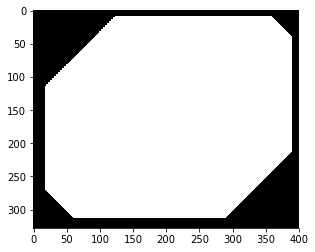

In [11]:
%%time
convex_hull = thickening_convex_hull(horse)
plt.imshow(convex_hull, cmap='gray')